In [ ]:
72
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-sentiment-analysis-hatred-speech:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F100982%2F239192%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T033928Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c1c6dbe733242e2b6fa2a7854343f6ecee2629674b0f722e65419e5d0f719056f022795cbbfb1613542f80c26814b7bcee823c926daaa8ccdaff35659634fb5c2af5e64f7cf9ff92c26d7d80c12130ea5307759649f61de41d4385c6b221c75739f29161ee9ba06f278367b6e9c37902bbbd73374809daad344bcb16ae5894eb0e02b7f09f76335f55ae4d4d0e09d32a03ae3184324fa80c9c164e902b51cfc2423246badaa603ba5612f158df434a8412eb788cd642c83bcb44824b203ceda97da7b9d44bbd0d5b0a248cc4c7bcd27ac2440a6adb7a0854d17a696bbc5e1947d1bb1acd201f3146bf38fe2ddd67bd6e1fe830df1b0bada9f56645a5f08ab9f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1982527 bytes downloaded
Downloaded and uncompressed: twitter-sentiment-analysis-hatred-speech
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


# Loading Libraries and Data

In [ ]:
import re  #Regular expression
import nltk #for Text manipulation
import string
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',200)

train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [ ]:
train[train['label']==1]

from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenny #kentucky
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'm proud! #mailboxpride #liberalisme
31947,31948,1,@user @user you don't have the balls to hashtag me as a but you say i am to weasel away.. lumpy tony.. dipshit.
31948,31949,1,"makes you ask yourself, who am i? then am i anybody? until ....god . oh thank you god!"


In [ ]:
test.shape, train.shape

((17197, 2), (31962, 3))

In [ ]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

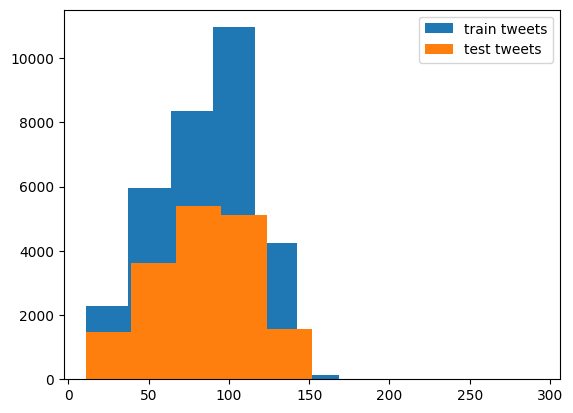

In [ ]:
length_train= train['tweet'].str.len()
length_test= test['tweet'].str.len()
plt.hist(length_train,label='train tweets')
plt.hist(length_test,label='test tweets')
plt.legend()
plt.show()

In [ ]:
combi=train.append(test,ignore_index=True)
combi.shape

(49159, 3)

# Data Cleaning

In [ ]:
def remove_pattern(input_txt, pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt= re.sub(i,'',input_txt)
    return input_txt

In [ ]:
#Removing twitter handles
combi['tidy_tweets']=np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')
combi.head()

,id,label,tweet,tidy_tweets
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [ ]:
#Removing punctuations, numbers, special characters
combi['tidy_tweets']=combi['tidy_tweets'].str.replace('[^a-zA-Z#]'," ")
combi.head()

,id,label,tweet,tidy_tweets
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [ ]:
#Removing short letter words
combi['tidy_tweets']=combi['tidy_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweets
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


# Text Normalisation

In [ ]:
#Tokenizing the tweet- Tokens are individual text whereas tokenisation is the process of splitting a string into tokens
tokenized_tweet= combi['tidy_tweets'].apply(lambda x:x.split()) #Tokenizing
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweets, dtype: object

In [ ]:
#Normalisation
from nltk.stem.porter import *
stemmer= PorterStemmer()
tokenized_tweet=tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #Stemming
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweets, dtype: object

In [ ]:
#nltk moses detokenizer to stitch these tokens back

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=''.join(tokenized_tweet[i])
combi['tidy_tweet']=tokenized_tweet
combi.head()

,id,label,tweet,tidy_tweets,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run,whenfatherdysfunctselfishdragkidintodysfunct#run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked,thank#lyftcreditcaustheyofferwheelchairvan#disapoint#getthank
2,3,0.0,bihday your majesty,bihday your majesty,bihdayyourmajesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time,#modellovetakewithtime
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation,factsguidsocieti#motiv


# Exploring and Visualising data

In [ ]:
#Wordcloud- is a way of visualisation where most frequent words appear in large size and the less frequent words small
all_words=' '.join([text for text in combi['tidy_tweets']])

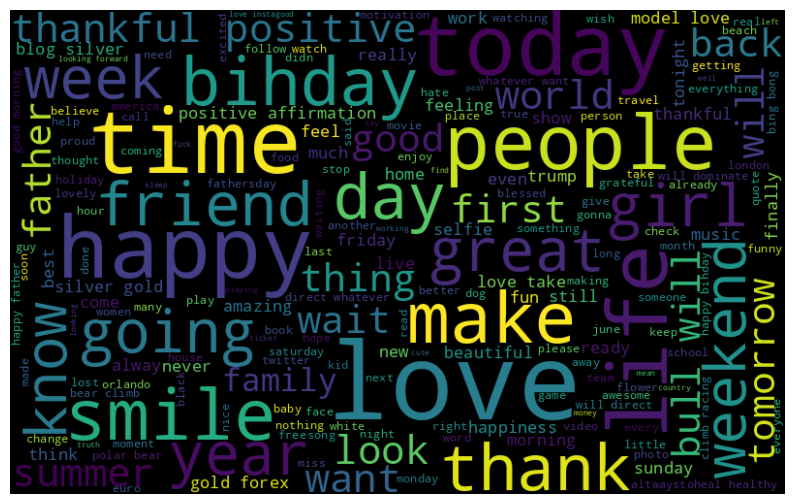

In [ ]:
from wordcloud import WordCloud
wordcloud=WordCloud(width=800,height=500, random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

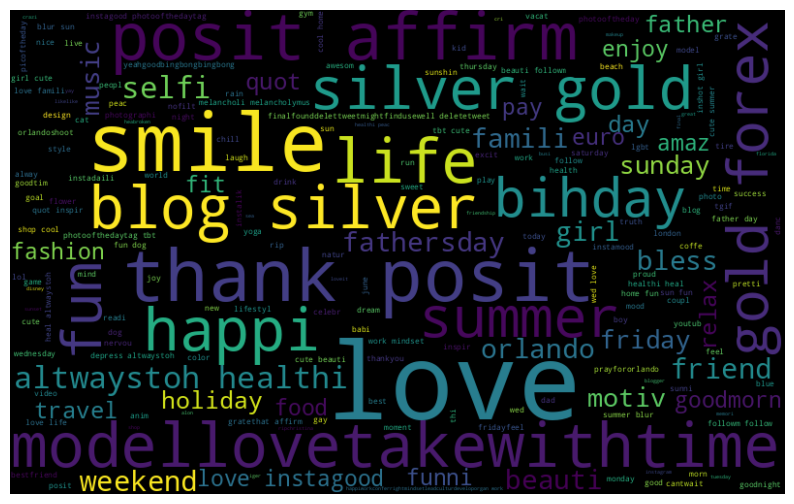

In [ ]:
normal_words= ' '.join([text for text in combi['tidy_tweet'][combi['label']==0]])
wordcloud=WordCloud(width=800,height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

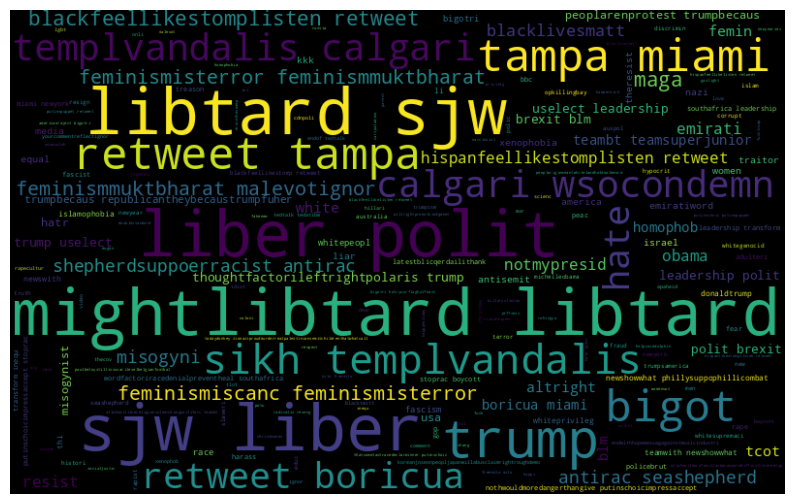

In [ ]:
racist_words= ' '.join([text for text in combi['tidy_tweet'][combi['label']==1]])
wordcloud=WordCloud(width=800,height=500, random_state=21, max_font_size=110).generate(racist_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Creating a function to extract hashtags from tweet
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht= re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

#Extracting regular hashtags
HT_regular=hashtag_extract(combi['tidy_tweet'][combi['label']==0])

#Extracting Sexist hashtags
HT_negative=hashtag_extract(combi['tidy_tweet'][combi['label']==1])

In [ ]:
HT_regular[1:5]

[['lyftcreditcaustheyofferwheelchairvan', 'disapoint', 'getthank'],
 [],
 ['modellovetakewithtime'],
 ['motiv']]

In [ ]:
#Unnesting list
HT_regular= sum(HT_regular,[])
HT_regular[1:5]

['lyftcreditcaustheyofferwheelchairvan',
 'disapoint',
 'getthank',
 'modellovetakewithtime']

In [ ]:
HT_negative=sum(HT_negative,[])
HT_negative[1:5]

['michiganmiddlschoolbuildwallchant', 'tcot', 'australia', 'opkillingbay']

In [ ]:
a=nltk.FreqDist(HT_regular)
a

FreqDist({'love': 1539, 'posit': 897, 'smile': 622, 'thank': 515, 'healthi': 504, 'fun': 450, 'affirm': 422, 'life': 397, 'summer': 371, 'cute': 356, ...})

In [ ]:
d=pd.DataFrame({'hashtag': list(a.keys()), 'count': list(a.values())})
d.head()

,hashtag,count
0,run,63
1,lyftcreditcaustheyofferwheelchairvan,1
2,disapoint,1
3,getthank,2
4,modellovetakewithtime,325


In [ ]:
d=d.nlargest(columns='count',n=20)
d

,hashtag,count
32,love,1539
39,posit,897
210,smile,622
38,thank,515
158,healthi,504
178,fun,450
92,affirm,422
354,life,397
296,summer,371
367,cute,356


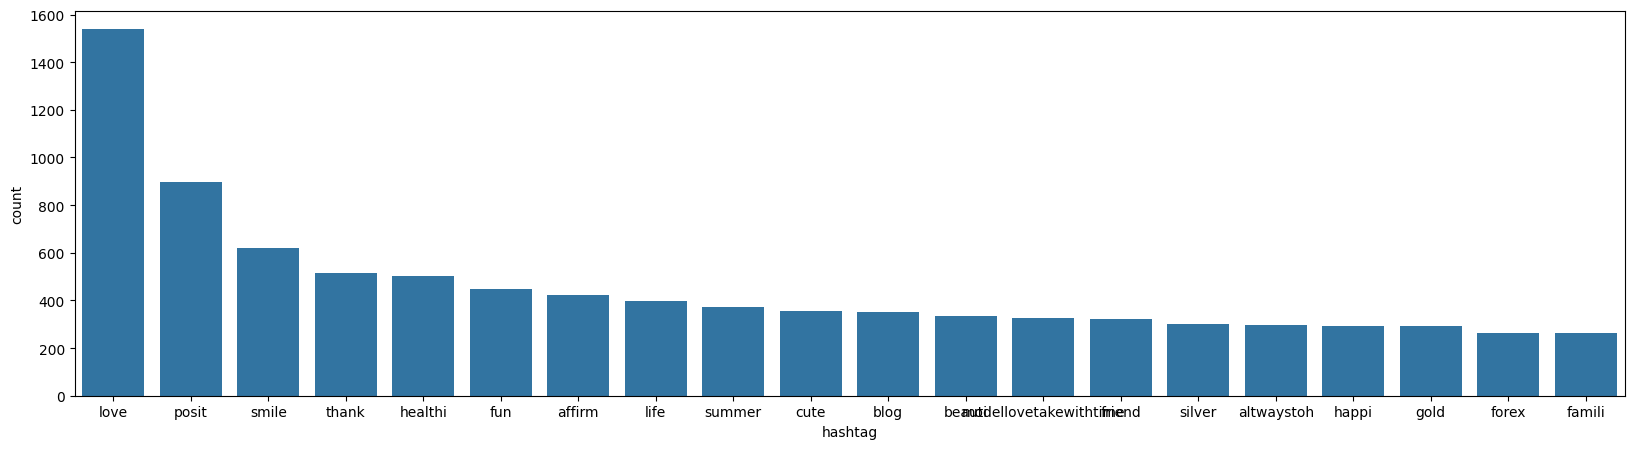

In [ ]:
#Visualizing the regular hashtags with the help of barplot
plt.figure(figsize=(20,5))
sns.barplot(data=d, x='hashtag', y='count')
plt.show()

In [ ]:
a=nltk.FreqDist(HT_negative)
a

FreqDist({'polit': 94, 'liber': 76, 'libtard': 74, 'sjw': 74, 'trump': 69, 'retweet': 63, 'miami': 44, 'tampa': 32, 'bigot': 30, 'hate': 27, ...})

In [ ]:
d=pd.DataFrame({'hashtag': (a.keys()), 'count': (a.values())})
d.head()

,hashtag,count
0,cnncall,2
1,michiganmiddlschoolbuildwallchant,2
2,tcot,13
3,australia,5
4,opkillingbay,5


In [ ]:
d=d.nlargest(columns='count',n=20)
d

,hashtag,count
32,polit,94
31,liber,76
29,libtard,74
30,sjw,74
147,trump,69
64,retweet,63
66,miami,44
65,tampa,32
74,bigot,30
38,hate,27


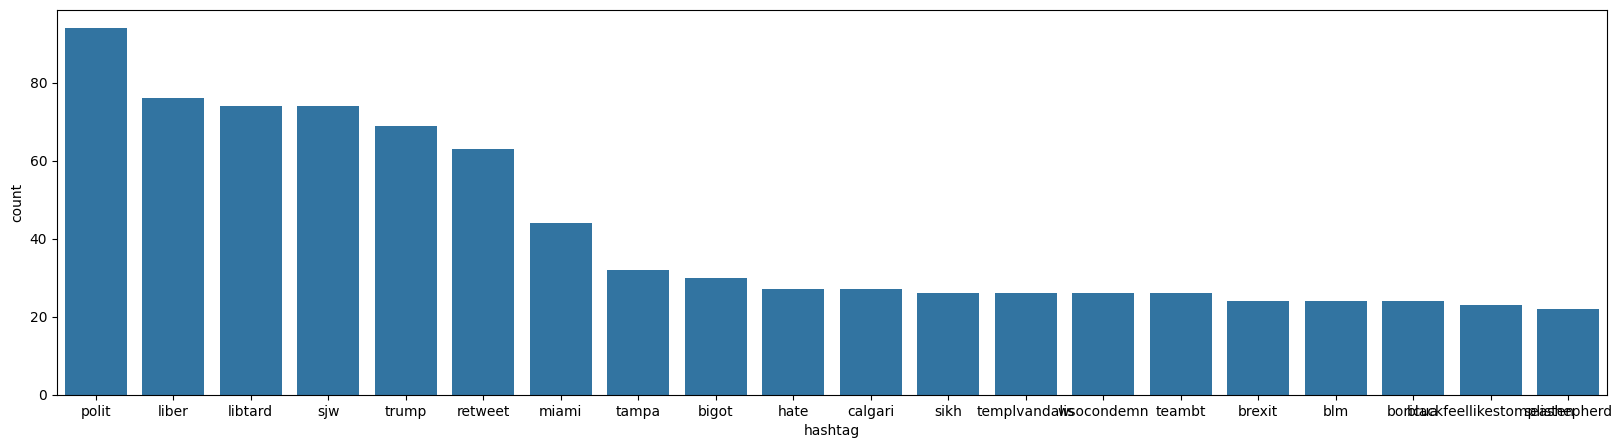

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(data=d, x='hashtag', y='count')
plt.show()

# Bag of words Features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [ ]:
bow_vectorizer= CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow= bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

# TF-IDF Features

In [ ]:
tfidf_vectorizer= TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf= tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [ ]:
'''# Word2Vec- low dimensions
tokenized_tweet= combi['tidy_tweet'].apply(lambda x:x.split())
model_w2v= gensim.models.Word2Vec(
            tokenized_tweet,
            size=200,
            window= 5, min_count=2, sg=1, hs=0, negative= 10, workers= 2)'''

"# Word2Vec- low dimensions\ntokenized_tweet= combi['tidy_tweet'].apply(lambda x:x.split())\nmodel_w2v= gensim.models.Word2Vec(\n            tokenized_tweet,\n            size=200,\n            window= 5, min_count=2, sg=1, hs=0, negative= 10, workers= 2)"

# Model Building - Logistic Regression

In [ ]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow=bow[:31962,:]
test_bow=bow[31962:, :]

xtrain,xtest,ytrain,ytest=train_test_split(train_bow,train['label'], test_size=0.25, random_state=1)

lreg=LogisticRegression()
lreg.fit(xtrain,ytrain)
pred=lreg.predict_proba(xtest)
pred_int=pred[:,1]>=0.2

In [ ]:
pred_int=pred_int.astype(np.int)
f1_score(ytest,pred_int)

0.4660691421254801

In [ ]:
test_pred=lreg.predict_proba(test_bow)
test_pred_int=test_pred[:,1]>=0.3
test_pred_int= test_pred_int.astype(np.int)
test['label']=test_pred_int
submission=test[['id','label']]
submission.to_csv('sub_lreg.csv',index=False)

In [ ]:
#TFIDF- Features

train_tfidf=tfidf[:31962,:]
test_tfidf=tfidf[31962:,:]

xtrain_t,xtest_t,ytrain_t,ytest_t= train_test_split(train_tfidf, train['label'],test_size=0.3, random_state=42)

lreg.fit(xtrain_t,ytrain_t)
pred= lreg.predict_proba(xtest_t)
pred= pred[:,1]>=0.3
pred=pred.astype(np.int)

f1_score(ytest_t,pred)

0.439344262295082

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc=SVC(kernel='linear', C=1, probability=True).fit(xtrain,ytrain)
pred=svc.predict_proba(xtest)
pred=pred[:,1]>=0.2
pred=pred.astype(np.int)
f1_score(ytest,pred)

0.445910290237467

In [ ]:
#Prediction for test data

test_pred=(svc.predict_proba(test_bow)[:,1]>=0.3).astype(np.int)
test['label']=test_pred
submission=test[['id','label']]
submission.to_csv('SVC.csv',index=False)

In [ ]:
#TFIDF- Features

svc=SVC(kernel='linear', C=1, probability=True).fit(xtrain_t,ytrain_t)
pred=svc.predict_proba(xtest_t)
pred=pred[:,1]>=0.3
pred=pred.astype(np.int)
f1_score(ytest_t,pred)

0.42919389978213507

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf=RandomForestClassifier(n_estimators= 400, random_state=100).fit(xtrain,ytrain)
pred=(rf.predict_proba(xtest)[:,1]>=0.30).astype(np.int)
f1_score(ytest,pred)

0.4510739856801909

In [ ]:
test_pred= rf.predict_proba(test_bow)
test['label']=test_pred
submission=test[['id','label']]
submission.to_csv('RandomForest.csv',index=False)

In [ ]:
#TFIDF features

rf=RandomForestClassifier(n_estimators= 400, random_state=100).fit(xtrain_t,ytrain_t)
pred=(rf.predict_proba(xtest_t)[:,1]>=0.30).astype(np.int)
f1_score(ytest_t,pred)

0.4444444444444444

# XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb=XGBClassifier(n_estimators= 1000, max_depth=6).fit(xtrain,ytrain)
pred=(xgb.predict_proba(xtest)[:,1]>=0.30).astype(np.int)
f1_score(ytest,pred)

0.4244897959183673

In [ ]:
test_pred= xgb.predict_proba(test_bow)
test['label']=test_pred
submission=test[['id','label']]
submission.to_csv('XGBClassifier.csv',index=False)

# Fine Tuning XGB

In [ ]:
import xgboost as xgb

In [ ]:
dtrain=xgb.DMatrix(xtrain,label=ytrain)
dtest=xgb.DMatrix(xtest,label=ytest)
d_test= xgb.DMatrix(test_bow)

In [ ]:
#Parameters

params={'objective': 'binary:logistic',
       'max_depth': 6,
       'min_child_weight': 1 ,
       'eta': 0.3,
       'subsample':1,
       'colsample_bytree':1}

In [ ]:
def custom_eval(preds, dtrain):
    labels=dtrain.get_label().astype(np.int)
    preds=(preds>0.3).astype(np.int)
    return [("f1_Score",f1_score(labels,preds))]

In [ ]:
gridsearch_params=[(max_depth, min_child_weight) for max_depth in range(6,10) for min_child_weight\
                  in range(5,8)]

max_f1=0
best_params=None
for max_depth, min_child_weight in gridsearch_params:
    print('CV with max_depth= {}, min_child_weight ={}'.format(max_depth, min_child_weight))
    params['max_depth']=max_depth
    params['min_child_weight']=min_child_weight

    cv_results= xgb.cv(params,dtrain, feval=custom_eval,num_boost_round=200, maximize=True, seed=16,\
                       nfold=5, early_stopping_rounds=10)



CV with max_depth= 6, min_child_weight =5
CV with max_depth= 6, min_child_weight =6
CV with max_depth= 6, min_child_weight =7
CV with max_depth= 7, min_child_weight =5
CV with max_depth= 7, min_child_weight =6
CV with max_depth= 7, min_child_weight =7
CV with max_depth= 8, min_child_weight =5
CV with max_depth= 8, min_child_weight =6
CV with max_depth= 8, min_child_weight =7
CV with max_depth= 9, min_child_weight =5
CV with max_depth= 9, min_child_weight =6
CV with max_depth= 9, min_child_weight =7
